Dataset
Dataset: Air Quality Dataset (UCI)
This dataset contains information on air quality, including different air quality parameters such as CO, NO2, and temperature.

Source: Air Quality Dataset - UCI

Objective
In this assignment, we will work on hyperparameter tuning and regularization techniques (L2 regularization, dropout) to analyze their effects on the model's performance for predicting air quality levels.

Solution with Visualizations
Below is the Python code for hyperparameter tuning and applying regularization techniques. It also includes multiple plots to evaluate how different hyperparameters and regularization techniques affect model performance.

<ipython-input-7-89f8cbf421e2>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Fill missing values
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Percentage of missing data per column:
Date               0.0
Time               0.0
CO(GT)             0.0
PT08.S1(CO)        0.0
NMHC(GT)           0.0
C6H6(GT)           0.0
PT08.S2(NMHC)      0.0
NOx(GT)            0.0
PT08.S3(NOx)       0.0
NO2(GT)            0.0
PT08.S4(NO2)       0.0
PT08.S5(O3)        0.0
T                  0.0
RH                 0.0
AH                 0.0
Unnamed: 15      100.0
Unnamed: 16      100.0
dtype: float64
Data shape after dropping columns with excessive missing values: (9471, 15)
Missing data after imputation: 0
Features (X) shape: (9471, 14)
Target (y) shape: (9471,)


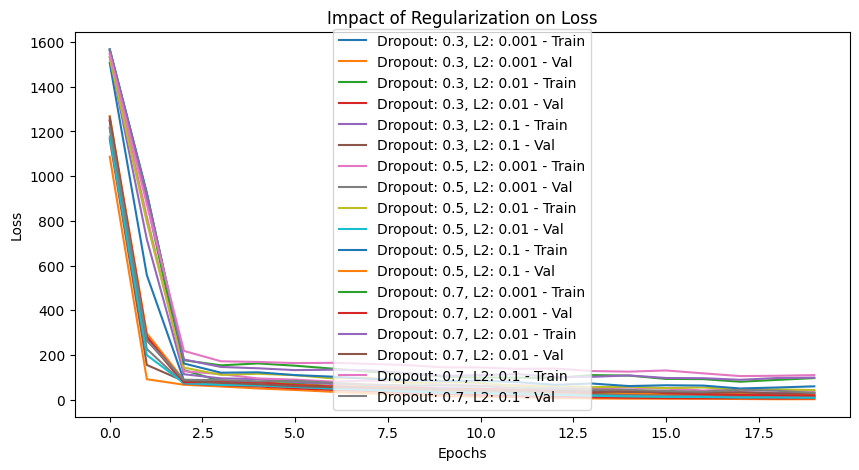

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


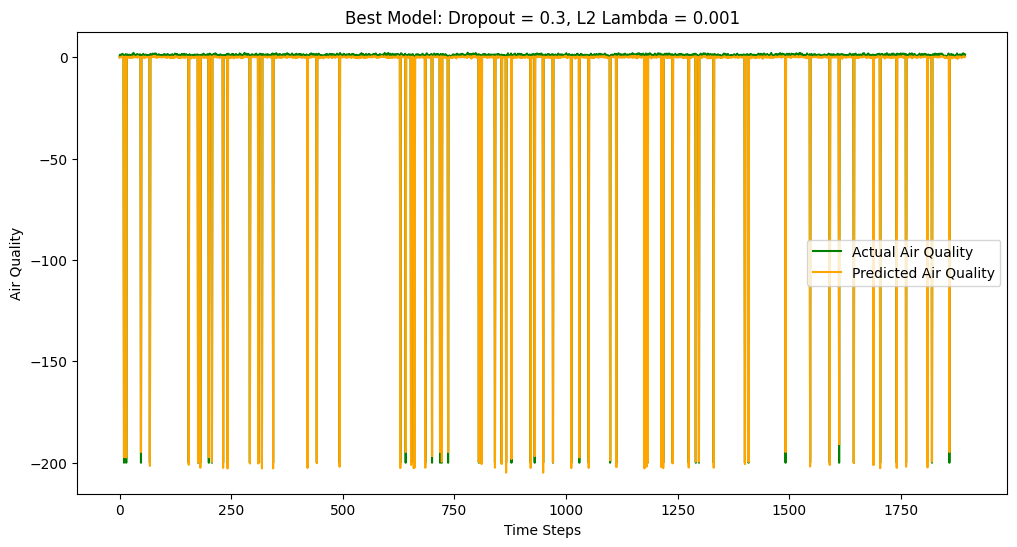

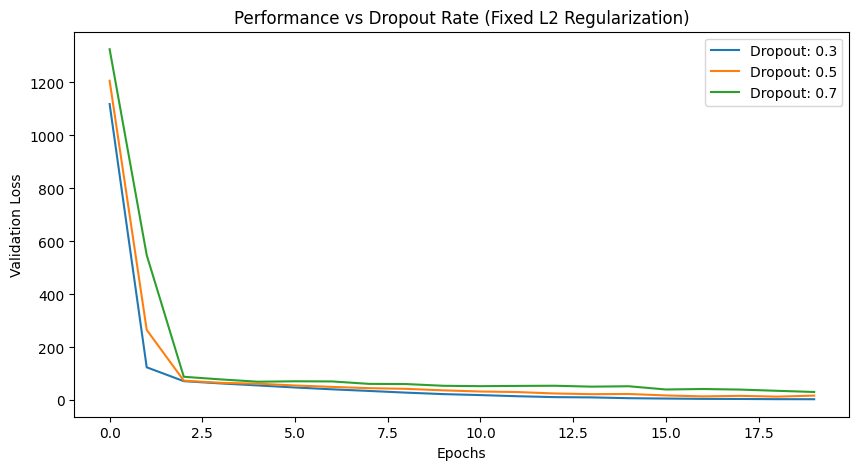

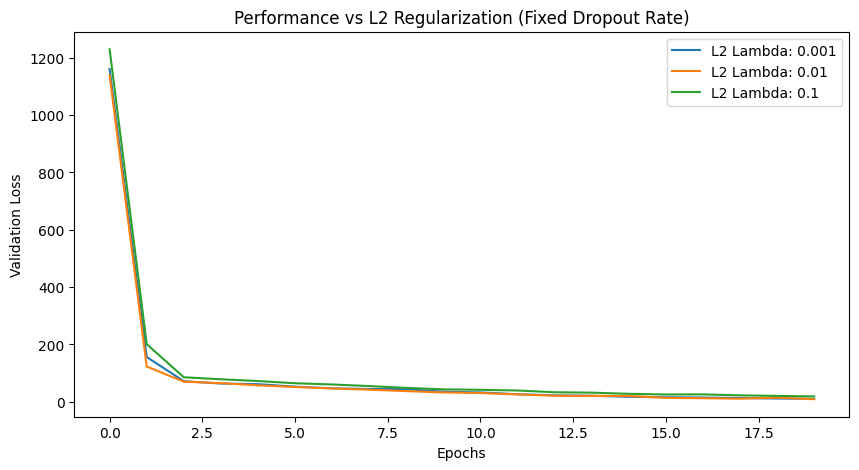

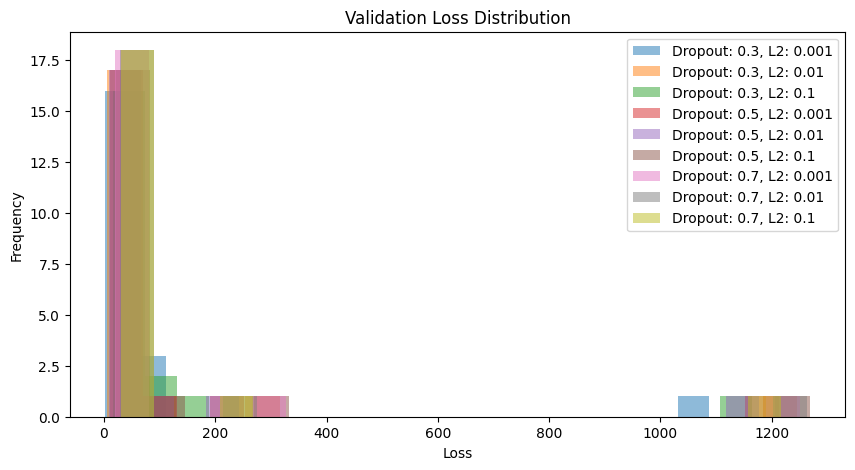

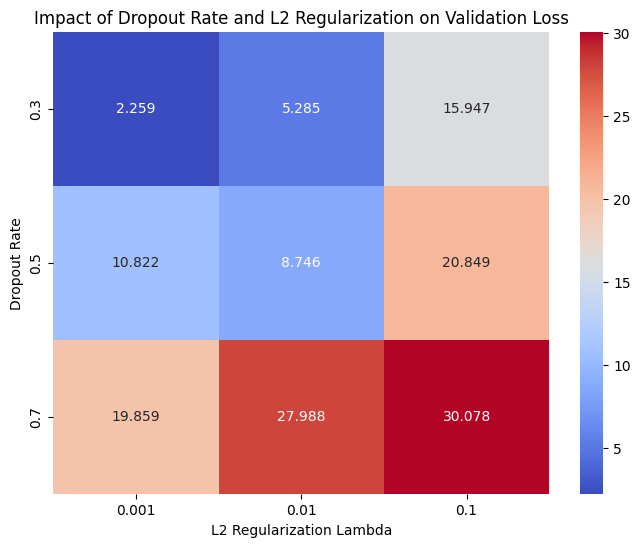

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import zipfile
import os
import requests

# Download and extract the ZIP file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
zip_path = "AirQualityUCI.zip"
extract_folder = "AirQualityUCI"

# Download the file
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extract the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Load the data from the extracted CSV file
data = pd.read_csv(os.path.join(extract_folder, 'AirQualityUCI.csv'), sep=';', decimal=',')
data = data.fillna(method='ffill')  # Fill missing values

# Check the percentage of missing values per column
missing_data = data.isnull().mean() * 100
print("Percentage of missing data per column:")
print(missing_data)

# If necessary, drop columns with too many missing values (e.g., more than 40%)
data = data.dropna(thresh=len(data) * 0.6, axis=1)

# Check the shape after dropping columns with excessive missing values
print(f"Data shape after dropping columns with excessive missing values: {data.shape}")

# Separate numeric and non-numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns
non_numeric_columns = data.select_dtypes(exclude=[np.number]).columns

# Use SimpleImputer to fill numeric columns with the median and non-numeric with the mode
imputer_numeric = SimpleImputer(strategy='median')
data[numeric_columns] = imputer_numeric.fit_transform(data[numeric_columns])

imputer_non_numeric = SimpleImputer(strategy='most_frequent')
data[non_numeric_columns] = imputer_non_numeric.fit_transform(data[non_numeric_columns])

# Check if any missing values remain
print(f"Missing data after imputation: {data.isnull().sum().sum()}")

# Select relevant features for prediction
X = data.iloc[:, :-1].values  # Exclude target column (CO concentration)
y = data.iloc[:, -1].values  # Target is the last column (CO concentration)

# Check the shape of X and y
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Ensure X contains only numeric data
X = data[numeric_columns].values  # Ensure only numeric columns are selected

# Normalize the feature data (X)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# For the target, it's better not to scale if you're evaluating CO concentration directly
y_min = y.min()
y_max = y.max()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model with hyperparameters and regularization
def create_model(dropout_rate=0.5, l2_lambda=0.01):
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda), input_dim=X_train.shape[1]),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Training and evaluation with different dropout rates and L2 regularization strengths
dropout_rates = [0.3, 0.5, 0.7]
l2_lambda_values = [0.001, 0.01, 0.1]

history_dict = {}

# Train models with different configurations
for dropout_rate in dropout_rates:
    for l2_lambda in l2_lambda_values:
        model = create_model(dropout_rate=dropout_rate, l2_lambda=l2_lambda)
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
        history_dict[(dropout_rate, l2_lambda)] = history

# 1. Training vs Validation Loss (Impact of Regularization)
plt.figure(figsize=(10, 5))
for (dropout_rate, l2_lambda), history in history_dict.items():
    plt.plot(history.history['loss'], label=f"Dropout: {dropout_rate}, L2: {l2_lambda} - Train")
    plt.plot(history.history['val_loss'], label=f"Dropout: {dropout_rate}, L2: {l2_lambda} - Val")
plt.title('Impact of Regularization on Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2. Final Model Performance (Model with best configuration)
best_config = min(history_dict, key=lambda x: min(history_dict[x].history['val_loss']))
best_model = create_model(dropout_rate=best_config[0], l2_lambda=best_config[1])
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Predictions and comparison with actual values
predictions = best_model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Air Quality', color='green')
plt.plot(predictions, label='Predicted Air Quality', color='orange')
plt.title(f"Best Model: Dropout = {best_config[0]}, L2 Lambda = {best_config[1]}")
plt.xlabel('Time Steps')
plt.ylabel('Air Quality')
plt.legend()
plt.show()

# 3. Model Performance vs Dropout Rate (Fixed L2 Regularization)
plt.figure(figsize=(10, 5))
for dropout_rate in dropout_rates:
    model = create_model(dropout_rate=dropout_rate, l2_lambda=0.01)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    plt.plot(history.history['val_loss'], label=f"Dropout: {dropout_rate}")
plt.title('Performance vs Dropout Rate (Fixed L2 Regularization)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# 4. Model Performance vs L2 Regularization (Fixed Dropout Rate)
plt.figure(figsize=(10, 5))
for l2_lambda in l2_lambda_values:
    model = create_model(dropout_rate=0.5, l2_lambda=l2_lambda)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)
    plt.plot(history.history['val_loss'], label=f"L2 Lambda: {l2_lambda}")
plt.title('Performance vs L2 Regularization (Fixed Dropout Rate)')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# 5. Loss Distribution Comparison (Dropout vs L2 Regularization)
plt.figure(figsize=(10, 5))
for config, history in history_dict.items():
    plt.hist(history.history['val_loss'], bins=20, alpha=0.5, label=f"Dropout: {config[0]}, L2: {config[1]}")
plt.title('Validation Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6. Heatmap of Hyperparameter Impact
loss_matrix = np.zeros((len(dropout_rates), len(l2_lambda_values)))
for i, dropout_rate in enumerate(dropout_rates):
    for j, l2_lambda in enumerate(l2_lambda_values):
        history = history_dict[(dropout_rate, l2_lambda)]
        loss_matrix[i, j] = min(history.history['val_loss'])

plt.figure(figsize=(8, 6))
sns.heatmap(loss_matrix, annot=True, xticklabels=l2_lambda_values, yticklabels=dropout_rates, cmap='coolwarm', fmt='.3f')
plt.title('Impact of Dropout Rate and L2 Regularization on Validation Loss')
plt.xlabel('L2 Regularization Lambda')
plt.ylabel('Dropout Rate')
plt.show()
